Quick Notes:
* Is this the same as the chisquare test I was using - https://www.itl.nist.gov/div898/handbook/prc/section4/prc46.htm
* Traditional test for which ranked items are significantly greater - https://www.itl.nist.gov/div898/handbook/prc/section4/prc474.htm
* Beta-Binomial Tutorial - http://sl8r000.github.io/ab_testing_statistics/use_a_hierarchical_model/
* Multilevel Beta-Binomial - https://dsaber.com/2016/08/27/analyze-your-experiment-with-a-multilevel-logistic-regression-using-pymc3%E2%80%8B/
* Another Beta Binomial Tutorial - https://blog.dominodatalab.com/ab-testing-with-hierarchical-models-in-python/
* Pymc3 Beta Binomial Tutorial - https://docs.pymc.io/notebooks/GLM-hierarchical-binominal-model.html
* Another pymc3 beta binomial - https://dsaber.com/2016/08/27/analyze-your-experiment-with-a-multilevel-logistic-regression-using-pymc3%E2%80%8B/
* Note how the beta priors are created (the 5/2 thing). Test this in other regression with pymc3 project.
* Multi-level beta binomial question - https://stats.stackexchange.com/questions/230034/extending-a-hierarchical-beta-binomial-model-to-account-for-higher-level-groups
* Multilevel pymc3 - https://austinrochford.com/posts/2017-07-09-mrpymc3.html
* Partial Pooling - https://docs.pymc.io/notebooks/hierarchical_partial_pooling.html

In [1]:
%%bash
head ../processed_data/all_errors_bip.out

aaroh101, Hank Aaron, 4, 496, 1968
aarot101, Tommie Aaron, 2, 234, 1968
abert101, Ted Abernathy, 0, 5, 1968
adaij101, Jerry Adair, 2, 180, 1968
adamm101, Mike Adamson, 0, 1, 1968
adled101, Dave Adlesh, 1, 72, 1968
ageet101, Tommie Agee, 8, 265, 1968
aguih101, Hank Aguirre, 0, 1, 1968
akerj102, Jack Aker, 0, 2, 1968
alcal101, Luis Alcaraz, 1, 83, 1968


In [2]:
import pandas as pd

DF = pd.read_csv('../processed_data/all_errors_bip.out',
                 header=None,
                 names=['playerid', 'player_name', 'errors', 'bip', 'year'])

In [3]:
DF.head()

,playerid,player_name,errors,bip,year
0,aaroh101,Hank Aaron,4,496,1968
1,aarot101,Tommie Aaron,2,234,1968
2,abert101,Ted Abernathy,0,5,1968
3,adaij101,Jerry Adair,2,180,1968
4,adamm101,Mike Adamson,0,1,1968


In [4]:
import numpy as np

GROUPED_DF = (DF
              .groupby("year")
              .agg({'errors': np.sum,
                    'bip': np.sum,
                   })
             )

GROUPED_DF["prop_error"] = GROUPED_DF["errors"] / GROUPED_DF["bip"]

In [5]:
GROUPED_DF.describe()

,errors,bip,prop_error
count,51.000000,51.000000,51.000000
mean,1708.039216,121771.960784,0.014140
std,184.392620,12333.240302,0.001840
min,1244.000000,81229.000000,0.010923
25%,1596.000000,118019.500000,0.012417
50%,1723.000000,122928.000000,0.014327
75%,1851.000000,131132.000000,0.015566
max,2036.000000,135936.000000,0.017586


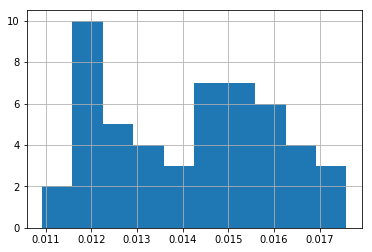

In [7]:
%matplotlib inline
GROUPED_DF["prop_error"].hist();

In [8]:
len(GROUPED_DF)

51

In [9]:
GROUPED_DF.head()

,errors,bip,prop_error
year,,,
1968,1534,88471,0.017339
1969,1862,108814,0.017112
1970,1845,109765,0.016809
1971,1635,109018,0.014998
1972,1640,103990,0.015771


In [10]:
GROUPED_DF

,errors,bip,prop_error
year,,,
1968,1534,88471,0.017339
1969,1862,108814,0.017112
1970,1845,109765,0.016809
1971,1635,109018,0.014998
1972,1640,103990,0.015771
1973,1874,111876,0.016751
1974,1850,112762,0.016406
1975,1973,112192,0.017586
1976,1790,112780,0.015872


In [11]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as tt

In [12]:
GROUPED_DF.shape

(51, 3)

In [13]:
with pm.Model() as bb_model:
 
    phi = pm.Uniform('phi', lower=0.0, upper=1.0)

    kappa_log = pm.Exponential('kappa_log', lam=1.5)
    kappa = pm.Deterministic('kappa', tt.exp(kappa_log))

    rates = pm.Beta('rates', alpha=phi*kappa, beta=(1.0-phi)*kappa, shape=len(GROUPED_DF))

 
    trials = np.array(GROUPED_DF["bip"])
    successes = np.array(GROUPED_DF["errors"])
 
    obs = pm.Binomial('observed_values', trials, rates,
                      observed=successes)
    trace = pm.sample(2000, tune=1000, chains=2, cores=2, nuts_kwargs={'target_accept': .95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rates, kappa_log, phi]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:30<00:00, 194.19draws/s]


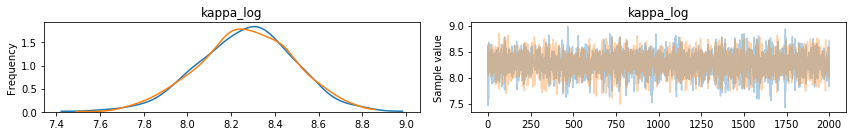

In [14]:
pm.traceplot(trace, varnames=['kappa_log']);

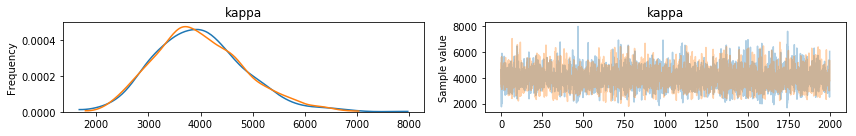

In [15]:
pm.traceplot(trace, varnames=['kappa']);

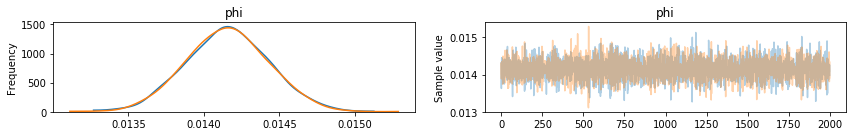

In [16]:
pm.traceplot(trace, varnames=['phi']);

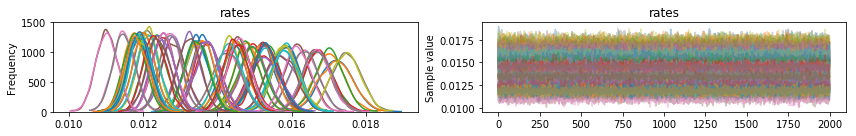

In [17]:
pm.traceplot(trace, varnames=['rates']);

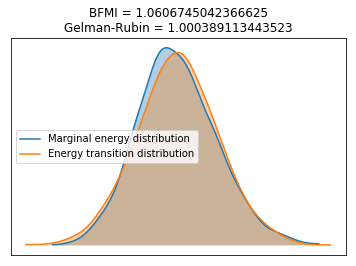

In [18]:
bfmi = pm.bfmi(trace)
max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(trace).values())
(pm.energyplot(trace, figsize=(6, 4)).set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

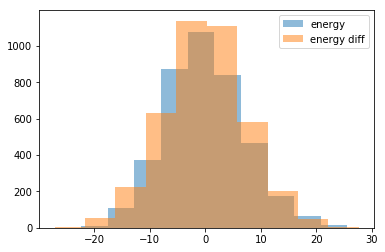

In [19]:
energy = trace['energy']
energy_diff = np.diff(energy)
plt.hist(energy - energy.mean(), label='energy', alpha=0.5)
plt.hist(energy_diff, label='energy diff', alpha=0.5)
plt.legend();

In [20]:
GROUPED_DF.head()

,errors,bip,prop_error
year,,,
1968,1534,88471,0.017339
1969,1862,108814,0.017112
1970,1845,109765,0.016809
1971,1635,109018,0.014998
1972,1640,103990,0.015771


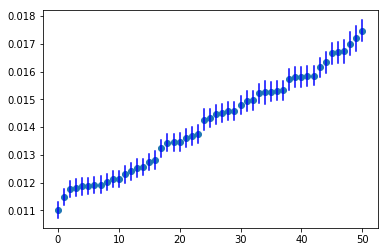

In [21]:
rate_means = trace['rates', 1000:].mean(axis=0)
rate_se = trace['rates', 1000:].std(axis=0)

mean_se = [(x, y, i) for i, x, y in zip(GROUPED_DF.index, rate_means, rate_se)]
sorted_means_se = sorted(mean_se, key=lambda x: x[0])
sorted_means = [x[0] for x in sorted_means_se]
sorted_se = [x[1] for x in sorted_means_se]

x = np.arange(len(sorted_means))

plt.plot(x, sorted_means, 'o');

for x_val, m, se in zip(x, sorted_means, sorted_se):
    plt.plot([x_val, x_val], [m-se, m+se], 'b-')

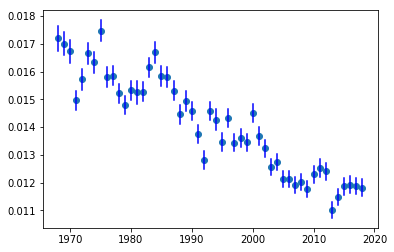

In [22]:
plt.plot(GROUPED_DF.index, rate_means, 'o');
for x_val, m, se in zip(GROUPED_DF.index, rate_means, rate_se):
    plt.plot([x_val, x_val], [m-se, m+se], 'b-')

In [23]:
sorted_means_se[:5]

[(0.011011680496334737, 0.00028428180520349855, 2013),
 (0.011479085002037233, 0.0002934659490447185, 2014),
 (0.011769051057939574, 0.00029153206076100083, 2009),
 (0.011817645482632833, 0.000298330035691104, 2018),
 (0.011862491079040331, 0.0003085671391091956, 2015)]

In [24]:
sorted_means_se[-5:]

[(0.016694408477005047, 0.00038003314701982334, 1984),
 (0.016724097724823316, 0.0003985186986550183, 1970),
 (0.01701073549632819, 0.00040345940085901254, 1969),
 (0.017198401082438704, 0.000456887853448958, 1968),
 (0.017469095683654505, 0.00037956537603057024, 1975)]

In [25]:
GROUPED_DF.loc[[x[2] for x in sorted_means_se[-5:]], :]

,errors,bip,prop_error
year,,,
1984,2036,121329,0.016781
1970,1845,109765,0.016809
1969,1862,108814,0.017112
1968,1534,88471,0.017339
1975,1973,112192,0.017586


In [26]:
GROUPED_DF.loc[[x[2] for x in sorted_means_se[:5]], :]

,errors,bip,prop_error
year,,,
2013,1413,129360,0.010923
2014,1460,128173,0.011391
2009,1547,132258,0.011697
2018,1459,124225,0.011745
2015,1511,128041,0.011801


GridSpec(1, 2, width_ratios=[3, 1])

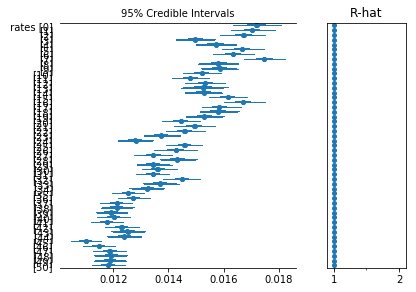

In [27]:
pm.plots.forestplot(trace, varnames=["rates"])